In [1]:
import random
from Environment import Environment
from CompanyAgent import CompanyAgent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tqdm

In [2]:
def generate_agents(
        count,
        expected_emission, 
        initial_allowance, 
        sell_price, 
        buy_price, 
        activate_abatement=True, 
        emission_rate_noise=0.01, 
        expected_emission_noise=0.1):
    
    agents = []
    for i in range(count):
        agents.append(CompanyAgent(
            expected_emission, 
            initial_allowance, 
            sell_price, 
            buy_price, 
            activate_abatement=activate_abatement, 
            emission_rate_noise=emission_rate_noise,
            expected_emission_noise=expected_emission_noise))
    return agents


In [11]:
random.seed(42)
np.random.seed(42)
# create two agents
# define 100 agents with random expected emission, initial allowance, sell price and buy price
agents = []
for i in range(100):
    expected_emission = np.random.uniform(800, 1200)
    initial_allowance = np.random.uniform(800, 1200)
    sell_price = np.random.uniform(0, 100)
    buy_price = np.random.uniform(0, 100)
    agents.append(CompanyAgent(expected_emission, initial_allowance, sell_price, buy_price, activate_abatement=False, emission_rate_noise=5))

for i in range(100):
    expected_emission = np.random.uniform(800, 1200)
    initial_allowance = np.random.uniform(800, 1200)
    sell_price = np.random.uniform(0, 100)
    buy_price = np.random.uniform(0, 100)
    agents.append(CompanyAgent(expected_emission, initial_allowance, sell_price, buy_price, activate_abatement=False, emission_rate_noise=5))


env = Environment(5, agents, mode="buyer_preferred")
print("start simulation")
for i in tqdm.tqdm(range(365)):
    env.update()


trade_df = pd.DataFrame(env.trade_hist_dict)
market_df = pd.DataFrame(env.market_hist_dict)

#join the two dataframes on days
df = pd.merge(trade_df, market_df, on="day")

start simulation


100%|██████████| 365/365 [07:51<00:00,  1.29s/it]


/home/david/miniconda3/envs/modsim/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/david/miniconda3/envs/modsim/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/david/miniconda3/envs/modsim/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/david/miniconda3/envs/modsim/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

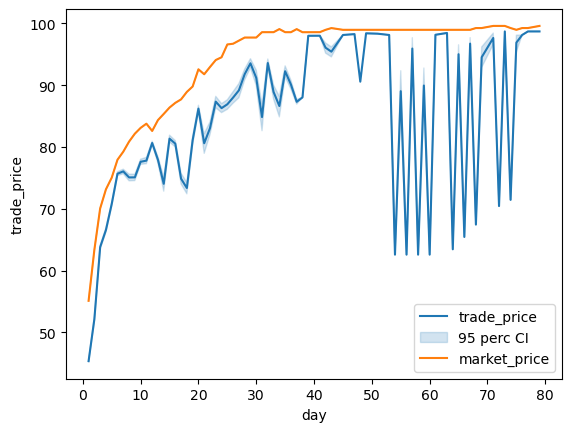

In [12]:
sns.lineplot(x="day", y="trade_price", data=df)
sns.lineplot(x="day", y="market_price", data=df)
plt.legend(["trade_price", "95 perc CI", "market_price"])
#add a line for the market price)
plt.show()

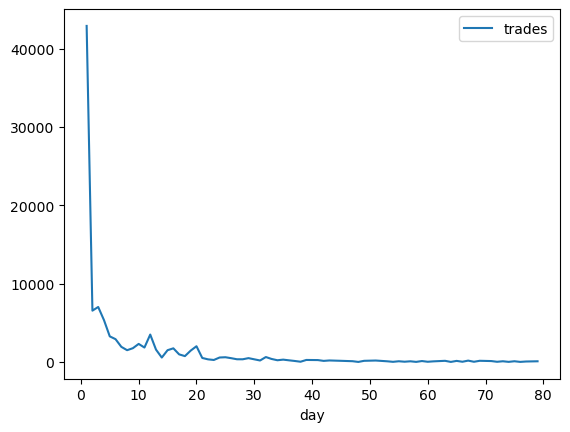

In [13]:
plt.figure()
df.groupby("day").trade_price.count().plot(kind="line")
plt.legend(["trades"])
plt.show()

In [10]:
import numpy as np
import numpy
q_supplier = np.random.normal(0, 1, 10000)
p_supplier = np.random.normal(0, 1, 10000)
q_demander = np.random.normal(0, 1, 10000)
p_demander = np.random.normal(0, 1, 10000)

In [8]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = numpy.result_type(*arrays)
    arr = numpy.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(numpy.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [14]:
q_supplier = np.array([1, 5, 8, 10])
p_supplier = np.array([0.3, 0.5, 0.7, 0.9])
q_demander = np.array([1, 3, 12, 15])
p_demander = np.array([1.2, 1.0, 0.8, 0.1])

In [ ]:
sns.

In [11]:
q_res = cartesian_product(q_supplier, q_demander)
p_res = cartesian_product(p_supplier, p_demander)

In [13]:
np.argmax((q_res[:,0] >= q_res[:,1]) & (p_res[:,0] > p_res[:,1]))

0